# Data Exploration with Open Source tools

In [2]:
import os
from azureml.core import Workspace, Dataset
from azureml.core.authentication import ServicePrincipalAuthentication


service_principal = ServicePrincipalAuthentication(
    tenant_id="502f2f1d-000c-410d-9d65-de9b3cfa9a83",
    service_principal_id="5203e379-a33a-4aea-bd8d-20bef410cc72",
    service_principal_password="9~by7nEl35Zv-3lntYqwm7b-15~ulIWHmw")


ws = Workspace(
    subscription_id='f9f80119-dbb0-496f-8e2c-351e0b95b66e',
    resource_group='bupa_demo',
    workspace_name='bupa_demo',
    auth=service_principal)

print("Found workspace {} at location {}".format(ws.name, ws.location))

Found workspace bupa_demo at location australiaeast


In [3]:
import pandas as pd
dataset = Dataset.get_by_name(ws, name='car_and_health_insurance_cross_sell')

df = dataset.to_pandas_dataframe()

df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Claims_Amount,Claims_Num
0,1,Male,44,1,28.0,0,> 2 Years,Yes,2753.018174,26.0,217,1,311,17
1,2,Male,76,1,3.0,0,1-2 Year,No,2282.227159,26.0,183,0,48,2
2,3,Male,47,1,28.0,0,> 2 Years,Yes,2606.023581,26.0,27,1,507,33
3,4,Male,21,1,11.0,1,< 1 Year,No,1947.610301,152.0,203,0,0,0
4,5,Female,29,1,41.0,1,< 1 Year,No,1871.186724,152.0,39,0,435,9


In [5]:
from sklearn.model_selection import train_test_split

import copy
import os

df_train, df_test = train_test_split(df, test_size=0.2, random_state=65)

print('Dataset sizes:')
print(f'\t->df_train size={df_train.shape[0]}')
print(f'\t->df_test size={df_test.shape[0]}')

Dataset sizes:
	->df_train size=304887
	->df_test size=76222


# 1. Quick EDA

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import pandas as pd

Looks like the most useful features to predict `Response` are:
- `Age`
- `Previously_Insured`
- `Policy_Sales_Channel`
- `Claimns_Amount`
- `Claims_Num`

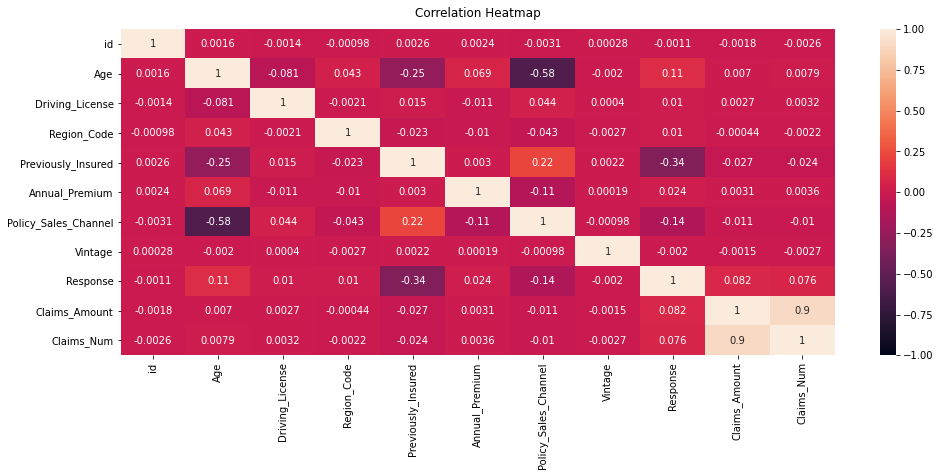

In [12]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_train.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

It looks like we are dealing with imbalanced dataset. `1` has 46.7k samples vs `0` 334.4k

In [19]:
display(df.groupby('Response').count()[['id']])

,id
Response,
0,334399
1,46710


In [20]:
response_1 = df_train[df_train['Response'] == 1]
response_0 = df_train[df_train['Response'] == 0]

df_train_balanced = pd.concat([response_1, response_0.sample(response_1.shape[0])])

In [23]:
import dbutils
correlated_features = ['Age', 'Previously_Insured', 'Policy_Sales_Channel', 'Claims_Amount', 'Claims_Num']

In [26]:
fig = px.histogram(df_train_balanced.sample(10000), x= correlated_features[0], marginal='box', color='Response')
fig.show()

# 2. Baseline Model

In [27]:
import pickle

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

In [28]:
import json
from mlflow.utils.file_utils import TempDir

In [40]:
def gender_encoder(df, use_prefix=False):
    _mapping = {'Male': 0, 'Female': 1}

    new_col = 'Gender'
    if use_prefix:
        new_col = 'x_Gender' 

    df[new_col] = df['Gender'].apply(lambda x: _mapping[x])
    return df
  
def vehicle_age_encoder(df, use_prefix=False):
    _mapping = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}

    new_col = 'Vehicle_Age'
    if use_prefix:
        new_col = 'x_Vehicle_Age' 

    df[new_col] = df['Vehicle_Age'].apply(lambda x: _mapping[x])
    return df
  
def vehicle_damage_encoder(df, use_prefix=False):
    _mapping = {'No': 0, 'Yes': 1}

    new_col = 'Vehicle_Damage'
    if use_prefix:
        new_col = 'x_Vehicle_Damage' 

    df[new_col] = df['Vehicle_Damage'].apply(lambda x: _mapping[x])
    return df


funcs = [
  gender_encoder,
  vehicle_age_encoder,
  vehicle_damage_encoder,
]

for f in funcs:
    df_train = f(df_train, True)
    df_test = f(df_test, True)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

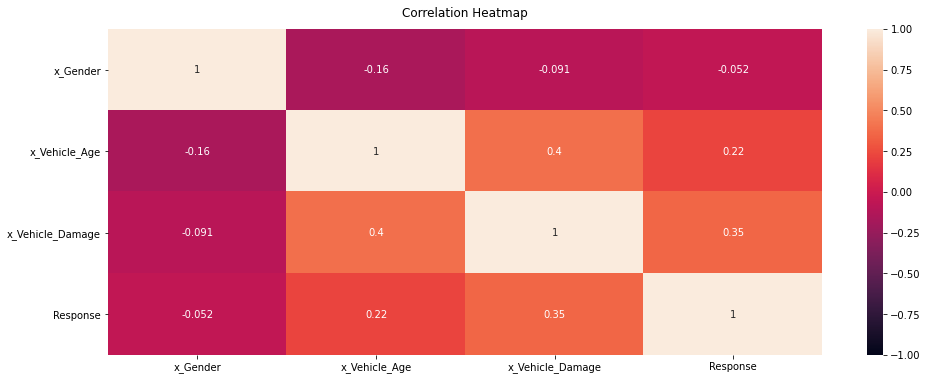

In [41]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_train[[c for c in df_train.columns if c.startswith('x')] + ['Response']].corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#### 3.1 Getting new features out

In [42]:
features = [
  'Age', 
  'Previously_Insured',
  'Policy_Sales_Channel',
  'Claims_Amount',
  'Claims_Num',
  'Driving_License',
  'Region_Code',
  'Annual_Premium',
  'Vintage',
  'x_Gender',
  'x_Vehicle_Age',
  'x_Vehicle_Damage'
]

label = 'Response'

X_train = df_train[features]
y_train = df_train[label]

X_test = df_test[features]
y_test = df_test[label]

#### 3.2 Let's try XGboost

In [43]:
import xgboost as xgb

In [44]:
# Looks promising, let's keep experimenting

params = {
  'max_depth': 2, 'reg_alpha': 0.01, 'reg_lambda': 0.01
}

xgb_model = xgb.XGBClassifier(**params).fit(X=X_train, y=y_train)
y_pred = xgb_model.predict(X_test)

f1_test = f1_score(y_test, y_pred)
print(f1_test)

0.07204495283965483


In [34]:
params = {
  'max_depth': 10, 'reg_alpha': 0.01, 'reg_lambda': 0.01
}

xgb_model = xgb.XGBClassifier(**params).fit(X=X_train, y=y_train)
y_pred = xgb_model.predict(X_test)

f1_test = f1_score(y_test, y_pred)
print(f1_test)

0.07204495283965483


In [35]:
params = {
  'max_depth': 2, 'reg_alpha': 0.05, 'reg_lambda': 0.01
}

xgb_model = xgb.XGBClassifier(**params).fit(X=X_train, y=y_train)
y_pred = xgb_model.predict(X_test)

f1_test = f1_score(y_test, y_pred)
print(f1_test)

0.07204495283965483
